In [1163]:
# ======================================================
# Project: Food Collector
# Authors: Gamaliel Marines Olvera A01708746
#          Juan Pablo Cabrera Quiroga
#          Sebastian Flores  Lemus A01709229
# Description: This script contains the implementation
#              of the Food Collector simulation and 
#              the server that allows the communication
#              between the simulation and the Unity
#              application.
# ======================================================

In [1164]:
# ======================================================
# Imports
# ======================================================

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import random

from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

import pandas as pd
import math

In [1165]:
#=============================================
# Deposit Agent
#=============================================

class DepositAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 1
        self.foodAmount = 0
        self.visible = False

    def RecieveFood(self):
        foodAmount +=1

In [1166]:
#=============================================
# Food Agent
#=============================================

class FoodAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 2
        # self.foodAmount = foodAmount
        self.active = True
        self.placed = False

In [1167]:
#=============================================
# Carrier Agent
#=============================================
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 3
        self.food_carried = False

    def moveRandom(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_steps_list = list(possible_steps)

        for step in possible_steps_list:
            if self.model.foods[step[0]][step[1]] != 0:
                possible_steps_list.remove(step)

        new_position = random.choice(possible_steps_list)

    def move2food(self):
        if not self.food_carried:
            pass
        return
    
    def communicate_food_position(self, food_position):
        pass

    def communicate_deposit_position(self, deposit_position):
        pass

    def move2warehouse(self):
        if self.food_carried:
            pass
        return
        
    def pickfood(self):
        self.food_carried = True
        return

    def dropfood(self):
        self.food_carried = False
        return

    def step(self):
        if not self.food_carried:
            self.move2food()
        elif self.food_carried:
            self.move2warehouse()



In [1168]:
# # ======================================================
# # Function: get_grid
# # Description: Gets the grid of the model.
# # Parameters:  model: The model where the grid belongs.
# # Return: The grid of the model.
# # ======================================================
# def get_grid(model):
#   grid = [[0 for x in range(model.grid.height)] for y in range(model.grid.width)]
#   for (content, (x, y)) in model.grid.coord_iter():
#     if content:
#         cell_type = 0
#         for agent in content:
#             cell_type = agent.type
#         grid[x][y] = cell_type

#   return grid

def get_grid(model):
    return get_colored_grid(model)


def get_color(agent_type):
    # DepositAgent
    if agent_type == 1:  
        return 'blue'
    # FoodAgent
    elif agent_type == 2:  
        return 'green'
    # RobotAgent
    elif agent_type == 3:  
        return 'brown'
    else:
        return 'yellow' 

def get_colored_grid(model):
    colored_grid = [['white' for x in range(model.grid.height)] for y in range(model.grid.width)]
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            for agent in content:
                colored_grid[x][y] = get_color(agent.type)

    return colored_grid


In [1169]:
# ======================================================
# Food Collector Model Class
# ======================================================
class FoodCollector(Model):
    # ==============================================================
    # Function: __init__
    # Description: Initializes the food collector model.
    # Parameters:  width: The width of the grid.
    #              height: The height of the grid.
    #              map: The map of the simulation.
    #              num_robots: The number of robots in the simulation.
    # Return:None
    # ==============================================================
    def __init__(self, width, height, num_agents):
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid" : get_grid})
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.food_id = 7
        self.food_counter = 0
        self.steps = 0
        self.food_pos = []
        deposit_box = None
        self.random.seed(12345)

        self.crear_agentes()

    def crear_agentes(self):
        agent_id = 1

        # Colocar Deposit
        deposit = DepositAgent(0, self)
        self.schedule.add(deposit)
        pos = self.random_empty_cell()
        self.grid.place_agent(deposit, pos)

        # Colocar los robots
        for _ in range(self.num_agents):
            robot = RobotAgent(agent_id, self)
            self.schedule.add(robot)
            pos = self.random_empty_cell()
            self.grid.place_agent(robot, pos)
            agent_id += 1
            print(f"Adding {agent_id} at step {self.steps}.")


    def add_food(self):
        if self.food_counter < 47:
            num_new_food = random.randint(2, 5)

            print(f"Adding {num_new_food} new food items at step {self.steps}.")

            for _ in range(num_new_food):
                if self.food_counter < 47:
                    food = FoodAgent(self.food_id, self)
                    self.schedule.add(food)
                    pos = self.random_empty_cell()
                    self.grid.place_agent(food, pos)
                    self.food_pos.append(pos)
                    self.food_counter += 1
                    self.food_id += 1

            print(f"Total food items: {self.food_counter} at {pos}")

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def step(self):
        if self.steps >= 5 and self.steps % 5 == 0:
            self.add_food()

        self.schedule.step()
        self.datacollector.collect(self)
        self.steps += 1

        # self.robot_initial_pos = (0, 0)
        # self.robotId = []
        # self.visited_positions = []
        # self.foods = set()
        # self.obstacles = set()
        # self.all_positions = [(x, y) for x in range(width) for y in range(height)]
        # self.robots_finished = set()
        # self.left_foodes = set()
        # self.scouting = False
        # self.clean = False

In [1170]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5

MAX_STEPS = 150

model = FoodCollector(WIDTH, HEIGHT, NUM_AGENTS)
for i in range(MAX_STEPS + 1):
    model.step()

data = model.datacollector.get_model_vars_dataframe()


Adding 2 at step 0.
Adding 3 at step 0.
Adding 4 at step 0.
Adding 5 at step 0.
Adding 6 at step 0.
Adding 3 new food items at step 5.
Total food items: 3 at (13, 2)
Adding 3 new food items at step 10.
Total food items: 6 at (5, 5)
Adding 2 new food items at step 15.
Total food items: 8 at (19, 19)
Adding 2 new food items at step 20.
Total food items: 10 at (11, 10)
Adding 4 new food items at step 25.
Total food items: 14 at (1, 9)
Adding 4 new food items at step 30.
Total food items: 18 at (3, 18)
Adding 5 new food items at step 35.
Total food items: 23 at (7, 13)
Adding 2 new food items at step 40.
Total food items: 25 at (14, 2)
Adding 5 new food items at step 45.
Total food items: 30 at (14, 18)
Adding 4 new food items at step 50.
Total food items: 34 at (5, 1)
Adding 3 new food items at step 55.
Total food items: 37 at (13, 0)
Adding 3 new food items at step 60.
Total food items: 40 at (4, 2)
Adding 5 new food items at step 65.
Total food items: 45 at (0, 4)
Adding 2 new food item

In [1171]:
all_grid = model.datacollector.get_model_vars_dataframe()

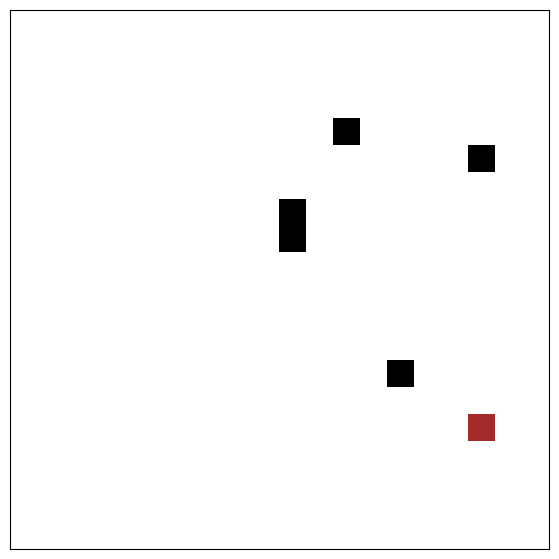

In [1172]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

cmap = ListedColormap(['white', 'lightblue', 'blue', 'green', 'brown', 'yellow', 'navy', 'midnightblue', 'black'])
numerical_grid = np.array([[cmap.colors.index(color) for color in row] for row in all_grid.iloc[0]['Grid']])
patch = plt.imshow(numerical_grid, cmap=cmap)

def animate(frame):
    current_grid = all_grid.iloc[frame]['Grid']
    numerical_grid = np.array([[cmap.colors.index(color) for color in row] for row in current_grid])
    patch.set_data(numerical_grid)
    return patch

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS + 1, interval=100)


In [1173]:
anim